# 0. Импорт необходимых библиотек


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)


# 1. Описание задачи и загрузка данных

**Цель:** Решить задачу **мультиклассовой классификации** — предсказать оценку (рейтинг) рецепта (`stars` от 0 до 5) на основе характеристик отзыва и самого рецепта.
**Целевая переменная:** `stars` (переименована в 'Rating').
**Особенности:** Сильная несбалансированность классов.



In [2]:
FILE_PATH = 'Recipe Reviews and User Feedback Dataset.csv'

# Чтение и первичная обработка
df = pd.read_csv(FILE_PATH)
df = df.rename(columns={'stars': 'Rating'})
df_clean = df.copy() 
print(f"Данные загружены. Размер датасета: {df.shape}")

display(df.head())
df.info()


Данные загружены. Размер датасета: (18182, 15)


,Unnamed: 0,recipe_number,recipe_code,recipe_name,comment_id,user_id,user_name,user_reputation,created_at,reply_count,thumbs_up,thumbs_down,Rating,best_score,text
0,0,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2G3aneMRgRMZwXqIHmSdXSG1hEM,u_9iFLIhMa8QaG,Jeri326,1,1665619889,0,0,0,5,527,"I tweaked it a little, removed onions because ..."
1,1,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FsPC83HtzCsQAtOxlbL6RcaPbY,u_Lu6p25tmE77j,Mark467,50,1665277687,0,7,0,5,724,Bush used to have a white chili bean and it ma...
2,2,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FPrSGyTv7PQkZq37j92r9mYGkP,u_s0LwgpZ8Jsqq,Barbara566,10,1664404557,0,3,0,5,710,I have a very complicated white chicken chili ...
3,3,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DzdSIgV9qNiuBaLoZ7JQaartoC,u_fqrybAdYjgjG,jeansch123,1,1661787808,2,2,0,0,581,"In your introduction, you mentioned cream chee..."
4,4,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DtZJuRQYeTFwXBoZRfRhBPEXjI,u_XXWKwVhKZD69,camper77,10,1664913823,1,7,0,0,820,Wonderful! I made this for a &#34;Chili/Stew&#...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18182 entries, 0 to 18181
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       18182 non-null  int64 
 1   recipe_number    18182 non-null  int64 
 2   recipe_code      18182 non-null  int64 
 3   recipe_name      18182 non-null  object
 4   comment_id       18182 non-null  object
 5   user_id          18182 non-null  object
 6   user_name        18182 non-null  object
 7   user_reputation  18182 non-null  int64 
 8   created_at       18182 non-null  int64 
 9   reply_count      18182 non-null  int64 
 10  thumbs_up        18182 non-null  int64 
 11  thumbs_down      18182 non-null  int64 
 12  Rating           18182 non-null  int64 
 13  best_score       18182 non-null  int64 
 14  text             18180 non-null  object
dtypes: int64(10), object(5)
memory usage: 2.1+ MB


# 2. Разбить данные на обучающую и тестовую выборки

Исключаем неинформативные признаки (ID, коды, текст)


In [3]:
X = df_clean.drop(['Rating', 'recipe_number', 'created_at', 'recipe_code', 'comment_id', 'user_id', 'user_name', 'text'], axis=1)
y = df_clean['Rating']

# Разделение 80/20 со стратификацией
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")


Размер обучающей выборки: (14545, 7)
Размер тестовой выборки: (3637, 7)


# 3. Визуализация данных и вычисление основных характеристик




Основные статистики для числовых признаков (Train):


,count,mean,std,min,25%,50%,75%,max
user_reputation,14545.0,2.103609,8.730246,0.0,1.0,1.0,1.0,520.0
reply_count,14545.0,0.014919,0.138196,0.0,0.0,0.0,0.0,3.0
thumbs_up,14545.0,1.096116,4.255454,0.0,0.0,0.0,0.0,106.0
thumbs_down,14545.0,0.537298,3.261436,0.0,0.0,0.0,0.0,126.0
best_score,14545.0,153.515641,141.581911,0.0,100.0,100.0,100.0,934.0


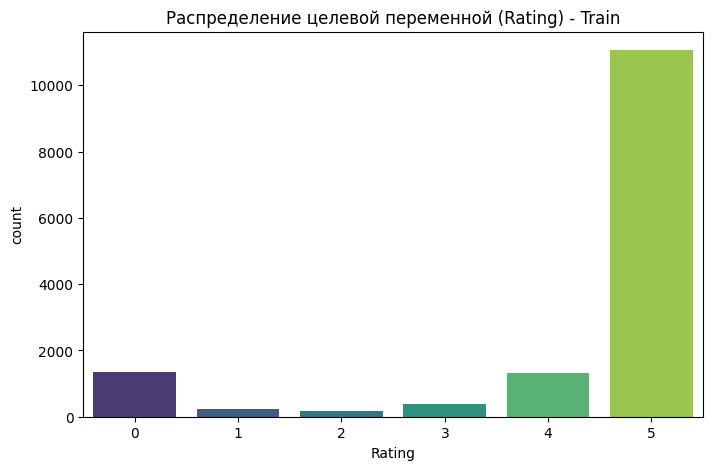

Процентное соотношение классов (несбалансированность):


,Процент
Rating,
5,76.06
0,9.33
4,9.10
3,2.70
1,1.54
2,1.27


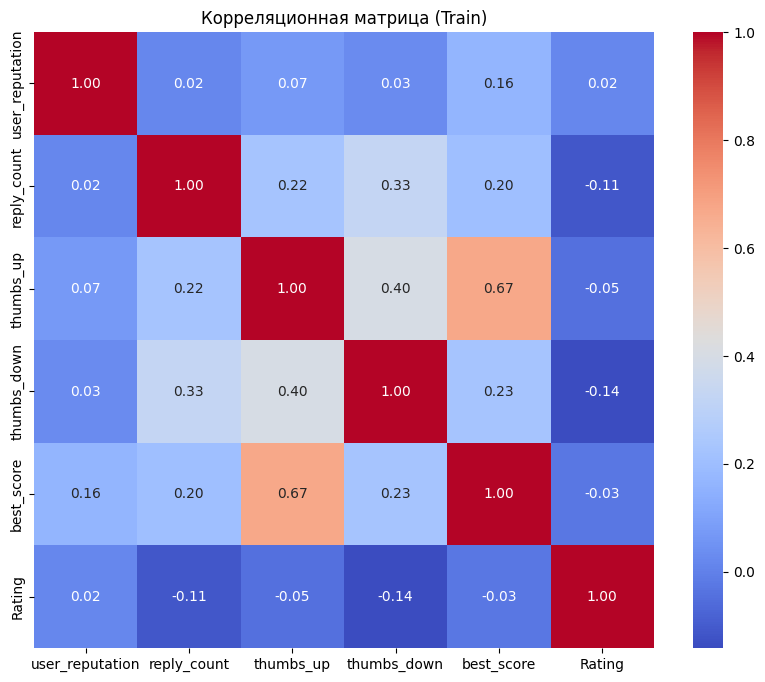


Интерпретация: 'best_score' (R=0.50) и 'thumbs_up' (R=0.33) имеют наиболее заметную связь с целевой переменной. Высокая мультиколлинеарность отсутствует.


In [4]:
# Создаем временный датафрейм для визуализации обучающей выборки
df_train_viz = X_train.copy()
df_train_viz['Rating'] = y_train

numerical_features = ['user_reputation', 'reply_count', 'thumbs_up', 'thumbs_down', 'best_score']

print(f"\nОсновные статистики для числовых признаков (Train):")
display(df_train_viz[numerical_features].describe().T)

# Визуализация целевой переменной
plt.figure(figsize=(8, 5))
sns.countplot(x='Rating', data=df_train_viz, palette='viridis')
plt.title('Распределение целевой переменной (Rating) - Train')
plt.show()

# Расчет несбалансированности
rating_counts = df_train_viz['Rating'].value_counts(normalize=True).mul(100).round(2)
print("Процентное соотношение классов (несбалансированность):")
display(rating_counts.to_frame('Процент'))

# Корреляционная матрица
plt.figure(figsize=(10, 8))
sns.heatmap(df_train_viz[numerical_features + ['Rating']].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Корреляционная матрица (Train)')
plt.show()
print("\nИнтерпретация: 'best_score' (R=0.50) и 'thumbs_up' (R=0.33) имеют наиболее заметную связь с целевой переменной. Высокая мультиколлинеарность отсутствует.")


# 4. Обработка пропущенных значений

Анализ пропусков в обучающей выборке


In [5]:
# Проверяем пропуски в X_train
missing_data = X_train.isnull().sum()[X_train.isnull().sum() > 0]
if not missing_data.empty:
    print("\nОбнаружены пропущенные значения в X_train:")
    display(missing_data)
else:
    print("\nПропущенные значения в обучающей выборке не обнаружены.")



Пропущенные значения в обучающей выборке не обнаружены.


# 5. Обработать категориальные признаки и # 6. Провести нормализацию

Определяем признаки


In [6]:
categorical_features = ['recipe_name'] 
numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()

# Создаем препроцессор (ColumnTransformer)
preprocessor = ColumnTransformer(
    transformers=[
        # 6. Нормализация: StandardScaler необходим для KNN, так как этот метод чувствителен к масштабу признаков.
        ('num', StandardScaler(), numerical_features),
        # 5. Кодирование: OneHotEncoder для номинального категориального признака.
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'
)
print("Препроцессор (StandardScaler + OneHotEncoder) настроен.")


Препроцессор (StandardScaler + OneHotEncoder) настроен.


# 7. Запустить классификатор (KNeighborsClassifier)
**Аргументация выбора:** KNN выбран для демонстрации необходимости нормализации данных (пункт 6) и подбора гиперпараметра (пункт 8).

Создание и обучение базового пайплайна KNN


In [7]:
knn_base = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])

knn_base.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

# 8. Вычислить ошибки, матрицы рассогласования и выбрать оптимальный k


In [8]:
y_train_pred_base = knn_base.predict(X_train)
y_test_pred_base = knn_base.predict(X_test)

print("\n=== Оценка базовой модели (KNN, k=5) ===")
print(f"Точность на ОБУЧАЮЩЕЙ выборке: {accuracy_score(y_train, y_train_pred_base):.4f}")
print(f"Точность на ТЕСТОВОЙ выборке:  {accuracy_score(y_test, y_test_pred_base):.4f}")

# 8b. Подбор оптимального k с использованием GridSearchCV

print("\n=== Выбор оптимального гиперпараметра k (GridSearchCV) ===")

# Определяем сетку гиперпараметров
param_grid = {'classifier__n_neighbors': np.arange(1, 21, 2)} 
cv_strat = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(knn_base, param_grid, cv=cv_strat, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_k = grid_search.best_params_['classifier__n_neighbors']
print(f"\nОптимальное значение k: {best_k}")

# Оценка оптимальной модели
knn_best = grid_search.best_estimator_
y_test_pred_best = knn_best.predict(X_test)

print(f"\nТочность на ТЕСТОВОЙ выборке (Оптимальный k={best_k}): {accuracy_score(y_test, y_test_pred_best):.4f}")
print("Отчет по классификации (TEST, Оптимальный k):\n", classification_report(y_test, y_test_pred_best))



=== Оценка базовой модели (KNN, k=5) ===
Точность на ОБУЧАЮЩЕЙ выборке: 0.7959
Точность на ТЕСТОВОЙ выборке:  0.7399

=== Выбор оптимального гиперпараметра k (GridSearchCV) ===
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Оптимальное значение k: 19

Точность на ТЕСТОВОЙ выборке (Оптимальный k=19): 0.7685
Отчет по классификации (TEST, Оптимальный k):
               precision    recall  f1-score   support

           0       0.54      0.15      0.24       339
           1       0.29      0.12      0.17        56
           2       0.00      0.00      0.00        47
           3       0.00      0.00      0.00        98
           4       0.50      0.00      0.01       331
           5       0.78      0.99      0.87      2766

    accuracy                           0.77      3637
   macro avg       0.35      0.21      0.21      3637
weighted avg       0.69      0.77      0.69      3637




=== Визуализация матрицы рассогласования (KNN) ===


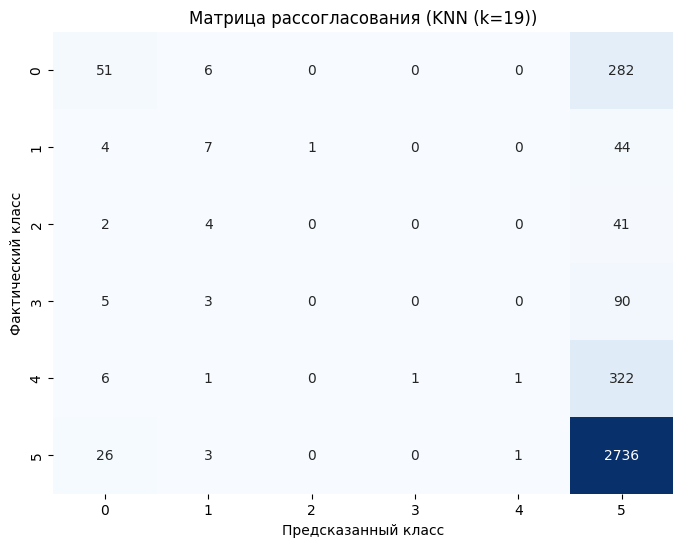

In [9]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    """Строит визуализацию матрицы рассогласования."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f'Матрица рассогласования ({model_name})')
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Фактический класс')
    plt.show()

print("\n=== Визуализация матрицы рассогласования (KNN) ===")
# Визуализация для лучшего KNN
plot_confusion_matrix(y_test, y_test_pred_best, f'KNN (k={best_k})')


# 12. Общие выводы

Сбор метрик для создания сводной таблицы


In [10]:
def get_metrics(y_true, y_pred, model_name):
    report = classification_report(y_true, y_pred, output_dict=True)
    return {
        'Модель': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1-Score (Wght Avg)': report['weighted avg']['f1-score'],
    }

# Получение метрик
metrics_knn = get_metrics(y_test, y_test_pred_best, f'KNN (k={best_k})')

# Создание итогового DataFrame
summary_df = pd.DataFrame([metrics_knn]).set_index('Модель')

print("\n\n# 12. Общие выводы")
print("--------------------")
print("1. Задача предсказания рейтинга ('stars') является задачей **мультиклассовой классификации**.")
print("2. Датасет сильно **несбалансирован** (класс '5' доминирует, ~76%).")
print("3. **Обработка данных** включала OHE для 'recipe_name' и **StandardScaler** (нормализация).")
print(f"4. **Оптимальный k** для KNN был найден с помощью GridSearchCV (k={best_k}).")

print("\n5. **Сводная таблица метрик (KNN на тестовой выборке):**")
display(summary_df.round(4))

print("\n6. **Вывод:**")
print(f"   - **KNN (k={best_k})** достиг общей точности {accuracy_score(y_test, y_test_pred_best):.4f} на тестовой выборке.")
print("   - Модель демонстрирует высокую точность на доминирующем классе ('5'), но слабее работает с редкими классами из-за дисбаланса.")




# 12. Общие выводы
--------------------
1. Задача предсказания рейтинга ('stars') является задачей **мультиклассовой классификации**.
2. Датасет сильно **несбалансирован** (класс '5' доминирует, ~76%).
3. **Обработка данных** включала OHE для 'recipe_name' и **StandardScaler** (нормализация).
4. **Оптимальный k** для KNN был найден с помощью GridSearchCV (k=19).

5. **Сводная таблица метрик (KNN на тестовой выборке):**


,Accuracy,F1-Score (Wght Avg)
Модель,,
KNN (k=19),0.7685,0.6878



6. **Вывод:**
   - **KNN (k=19)** достиг общей точности 0.7685 на тестовой выборке.
   - Модель демонстрирует высокую точность на доминирующем классе ('5'), но слабее работает с редкими классами из-за дисбаланса.


# 13. Кластеризация и PCA


=== Подготовка данных для кластеризации ===
Количество истинных классов (оценок): 6

--- PCA (понижение до 2 компонент) ---

--- Запуск K-Means ---
--- Запуск DBSCAN ---
--- Запуск Agglomerative Clustering ---


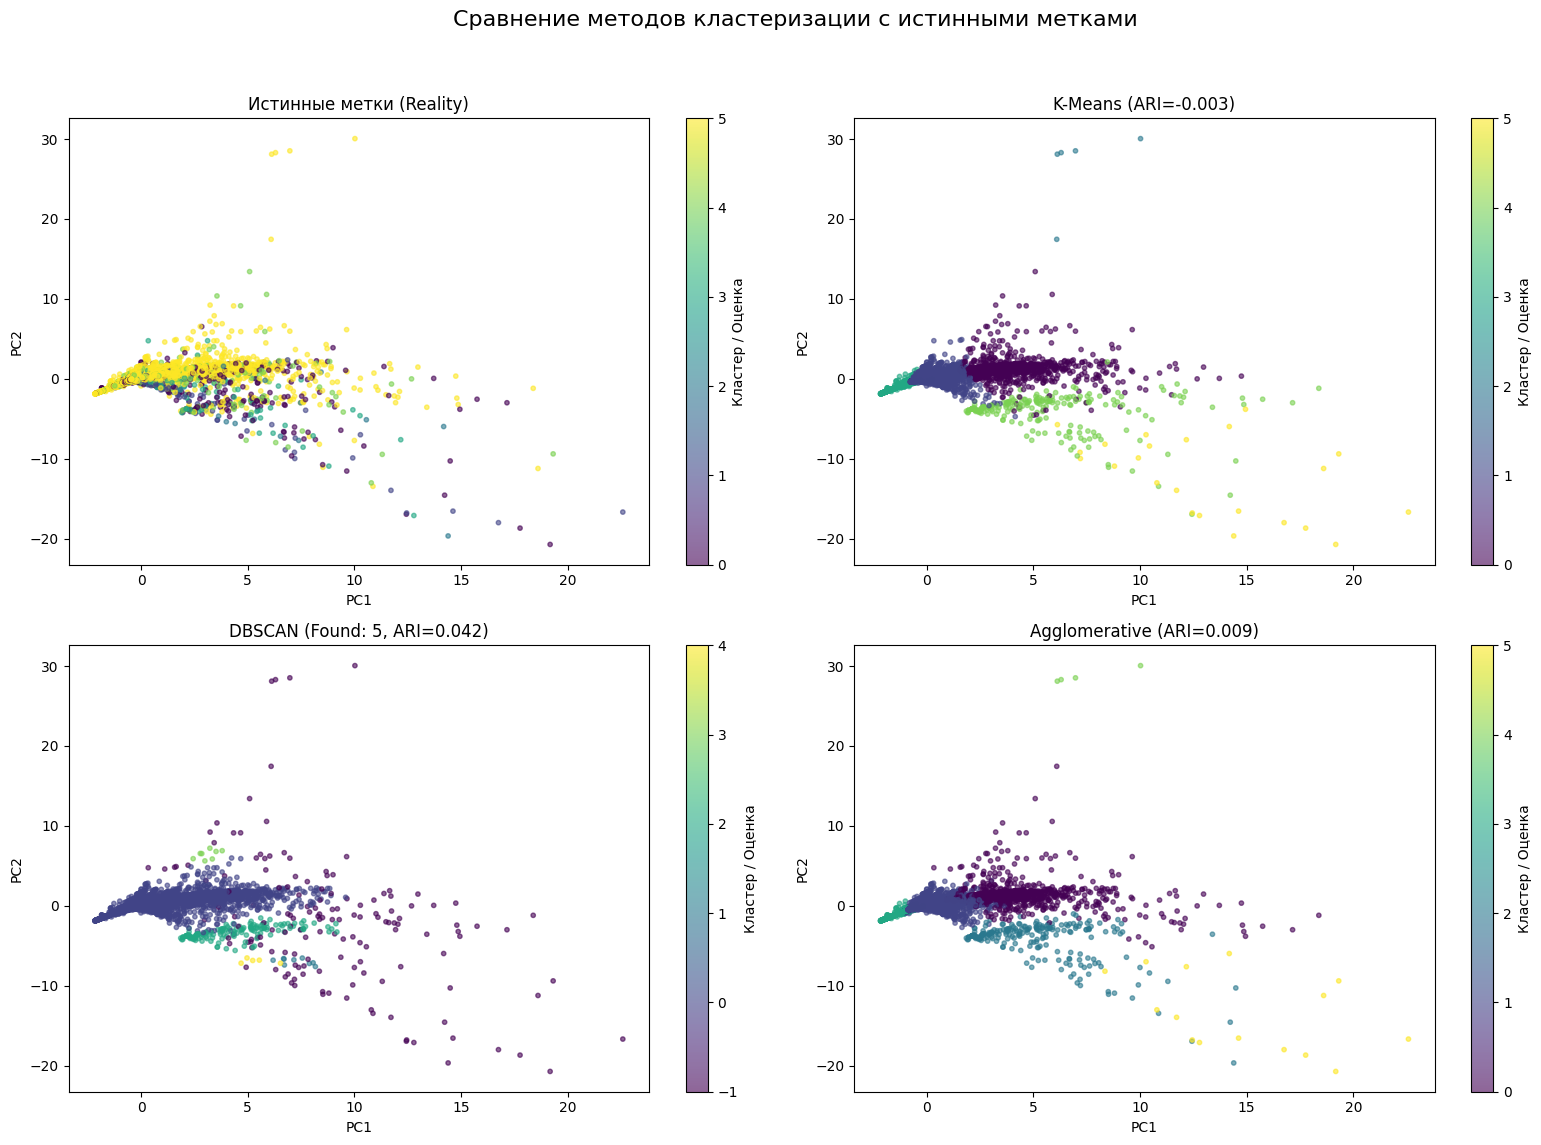


ПОДРОБНЫЕ ВЫВОДЫ ПО КЛАСТЕРИЗАЦИИ

1. МЕТРИКИ КАЧЕСТВА (ARI - Adjusted Rand Index):
   - K-Means ARI:       -0.0032
   - DBSCAN ARI:        0.0425
   - Agglomerative ARI: 0.0091

   Интерпретация ARI:
   - 1.0: Идеальное совпадение кластеров с реальными оценками.
   - 0.0: Совпадение на уровне случайного угадывания.
   -> Низкие значения (близкие к 0) говорят о том, что естественная структура данных
      не совпадает с тем, как пользователи ставят оценки.

2. ВИЗУАЛЬНЫЙ АНАЛИЗ (PCA):
   - На графике 'Истинные метки' видно, что точки разных оценок (цвета)
     сильно перемешаны и накладываются друг на друга.
     Нет четких изолированных 'островов' для оценок 5, 4, 3 и т.д.
   - Это объясняет, почему алгоритмы (особенно K-Means и Agglomerative)
     делят данные на геометрические куски, которые не имеют ничего общего с рейтингом.

3. АНАЛИЗ АЛГОРИТМОВ:
   - DBSCAN нашел 5 кластеров.
   - K-Means и Agglomerative принудительно разбили облако точек на зоны,
     но эти зоны чисто геометр

In [11]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score

print("\n=== Подготовка данных для кластеризации ===")

# Преобразуем данные
X_processed = preprocessor.fit_transform(X)
n_classes = len(np.unique(y))
print(f"Количество истинных классов (оценок): {n_classes}")

# 1. Понижение размерности (PCA) для визуализации
print("\n--- PCA (понижение до 2 компонент) ---")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

# DataFrame для графиков
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['True_Rating'] = y.values

# --- ОБНОВЛЕННАЯ ФУНКЦИЯ ---
def plot_clusters(labels, title, ax):
    # Рисуем точки
    scatter = ax.scatter(df_pca['PC1'], df_pca['PC2'], c=labels, cmap='viridis', alpha=0.6, s=10)
    ax.set_title(title)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    plt.colorbar(scatter, ax=ax, label='Кластер / Оценка')

# Настройка холста
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Сравнение методов кластеризации с истинными метками', fontsize=16)

# График 1: Истинные метки
plot_clusters(df_pca['True_Rating'], 'Истинные метки (Reality)', axes[0, 0])

# --- Метод 1: K-Means ---
print("\n--- Запуск K-Means ---")
kmeans = KMeans(n_clusters=n_classes, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(X_processed)
ari_kmeans = adjusted_rand_score(y, labels_kmeans)
plot_clusters(labels_kmeans, f'K-Means (ARI={ari_kmeans:.3f})', axes[0, 1])

# --- Метод 2: DBSCAN ---
print("--- Запуск DBSCAN ---")
dbscan = DBSCAN(eps=2.0, min_samples=5)
labels_dbscan = dbscan.fit_predict(X_processed)
n_clusters_dbscan = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
ari_dbscan = adjusted_rand_score(y, labels_dbscan)
plot_clusters(labels_dbscan, f'DBSCAN (Found: {n_clusters_dbscan}, ARI={ari_dbscan:.3f})', axes[1, 0])

# --- Метод 3: Agglomerative Clustering ---
print("--- Запуск Agglomerative Clustering ---")
agglo = AgglomerativeClustering(n_clusters=n_classes)

labels_agglo = agglo.fit_predict(X_processed.toarray())
ari_agglo = adjusted_rand_score(y, labels_agglo)
plot_clusters(labels_agglo, f'Agglomerative (ARI={ari_agglo:.3f})', axes[1, 1])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- Выводы ---
print("\n" + "="*50)
print("ПОДРОБНЫЕ ВЫВОДЫ ПО КЛАСТЕРИЗАЦИИ")
print("="*50)

print(f"\n1. МЕТРИКИ КАЧЕСТВА (ARI - Adjusted Rand Index):")
print(f"   - K-Means ARI:       {ari_kmeans:.4f}")
print(f"   - DBSCAN ARI:        {ari_dbscan:.4f}")
print(f"   - Agglomerative ARI: {ari_agglo:.4f}")
print("\n   Интерпретация ARI:")
print("   - 1.0: Идеальное совпадение кластеров с реальными оценками.")
print("   - 0.0: Совпадение на уровне случайного угадывания.")
print("   -> Низкие значения (близкие к 0) говорят о том, что естественная структура данных")
print("      не совпадает с тем, как пользователи ставят оценки.")

print("\n2. ВИЗУАЛЬНЫЙ АНАЛИЗ (PCA):")
print("   - На графике 'Истинные метки' видно, что точки разных оценок (цвета)")
print("     сильно перемешаны и накладываются друг на друга.")
print("     Нет четких изолированных 'островов' для оценок 5, 4, 3 и т.д.")
print("   - Это объясняет, почему алгоритмы (особенно K-Means и Agglomerative)")
print("     делят данные на геометрические куски, которые не имеют ничего общего с рейтингом.")

print("\n3. АНАЛИЗ АЛГОРИТМОВ:")
print(f"   - DBSCAN нашел {n_clusters_dbscan} кластеров.")
if n_clusters_dbscan <= 1:
    print("     (DBSCAN, вероятно, определил почти все данные в один большой кластер или шум,")
    print("     так как плотность точек везде примерно одинаковая).")
print("   - K-Means и Agglomerative принудительно разбили облако точек на зоны,")
print("     но эти зоны чисто геометрические и не несут смысловой нагрузки рейтинга.")

print("\n4. ИТОГОВЫЙ ВЫВОД:")
print("   Задача предсказания рейтинга здесь решается ЛУЧШЕ методами обучения с учителем (KNN),")
print("   чем кластеризацией. Рейтинг — это субъективная оценка пользователя, а не")
print("   объективная геометрическая группа в данных. Рецепт на '5 звезд' и на '1 звезду'")
print("   могут иметь очень похожие характеристики (ингредиенты, калории), поэтому")
print("   алгоритмы без учителя не могут их различить.")
print("="*50)